In [207]:
import numpy as np
from matplotlib import pyplot as plt
import os

%matplotlib inline

In [208]:
# datapath = '../../../data/tv-color/white-black-2Hz/'
# datapath = '../../../data/tv-color/red-black-1s/'
datapath = '../../../data/tv-color/black/'
recData = np.load(os.path.join(datapath, 'recording.npy'))
calFrame = np.load(os.path.join(datapath, 'calibration.npy'))
# recData -= calFrame[0, :, :]
cfg = np.load(os.path.join(datapath, './config.npy'), allow_pickle=True).item()

In [209]:
nfft = cfg['nfft']
dist_vec = cfg['dist_vec']

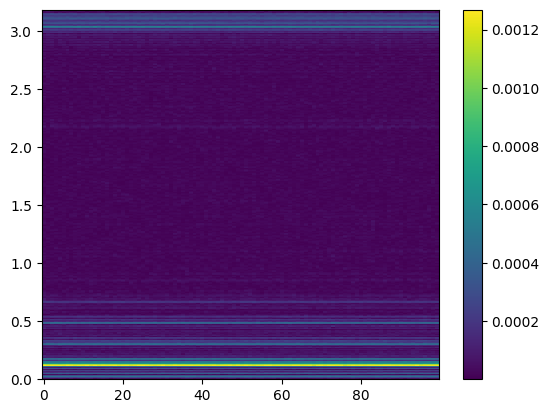

In [211]:
rp = np.fft.ifft(recData[:, 0, :], axis=1, n=nfft) # frames, range bins

plt.pcolormesh(np.arange(100), dist_vec, np.abs(rp.T))
plt.colorbar()

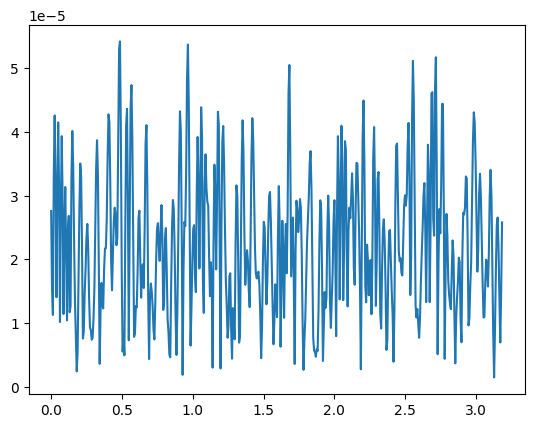

In [188]:
plt.plot(dist_vec, np.abs(rp[0, :]))

In [118]:
nfft_doppler = 256
rd = np.fft.fft(rp, axis=0, n=nfft_doppler) # doppler, range bins

Text(0.5, 1.0, 'Range doppler')

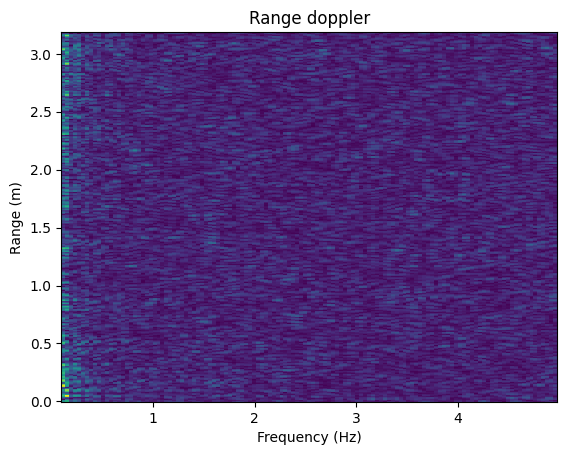

In [119]:
freq_vec = np.arange(nfft_doppler) * 10 / nfft_doppler
plt.pcolormesh(freq_vec[3:nfft_doppler//2], dist_vec, np.abs(rd[3:nfft_doppler//2, :].T))
plt.ylabel("Range (m)")
plt.xlabel("Frequency (Hz)")
plt.title("Range doppler")

In [120]:
tv_bin = np.argmax(np.sum(np.abs(rp), axis=0)[:nfft//2], axis=0)
tv_bin

8

Text(0.5, 1.0, 'Range doppler at screen range bin')

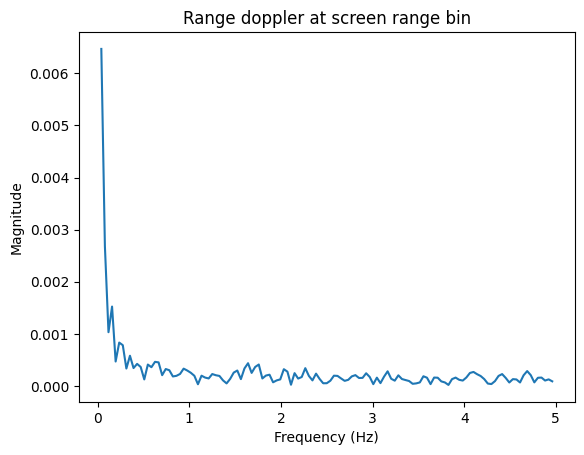

In [121]:
plt.plot(freq_vec[1:nfft_doppler//2], np.abs(rd[1:nfft_doppler//2, tv_bin]))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Range doppler at screen range bin")

Text(0.5, 0, 'Frames * Tx')

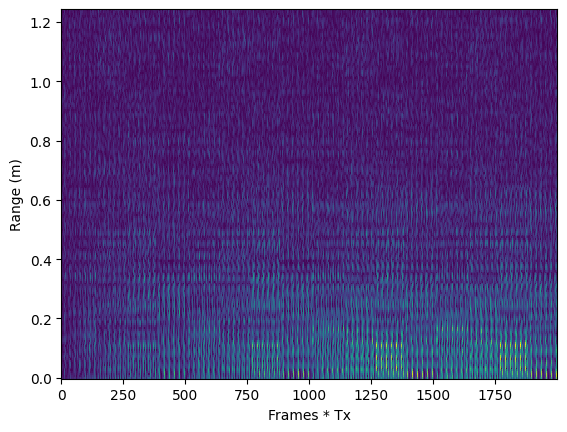

In [122]:
txData = np.reshape(recData, (recData.shape[0] * 20, 20, recData.shape[2]))
txData = txData[:, 0, :] # frames * tx, steps
rp_tx = np.fft.ifft(txData, axis=1, n=nfft) # frames, range bins
plt.pcolormesh(np.arange(2000), dist_vec[:200], np.abs(rp_tx[:, :200].T))
plt.ylabel("Range (m)")
plt.xlabel("Frames * Tx")

Text(0.5, 0, 'Frequency (Hz)')

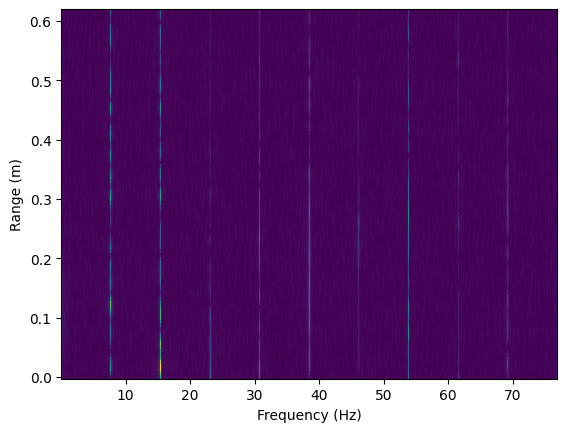

In [123]:
nfft_tx_doppler = 4096
rd_tx = np.fft.fft(rp_tx, axis=0, n=nfft_tx_doppler) # doppler, range bins
fs_tx = 1 / (0.13 / 20)
freq_tx_vec = np.arange(nfft_tx_doppler) * fs_tx / nfft_tx_doppler
plt.pcolormesh(freq_tx_vec[1:nfft_tx_doppler//2], dist_vec[:100], np.abs(rd_tx[1:nfft_tx_doppler//2, :100].T))
plt.ylabel("Range (m)")
plt.xlabel("Frequency (Hz)")

(array([   2,  204,  409,  613,  818, 1023, 1228, 1432, 1637], dtype=int64),
 {'peak_heights': array([0.02143921, 0.02172235, 0.07996411, 0.06465557, 0.02977658,
         0.03651588, 0.03027022, 0.02737874, 0.03594397])})

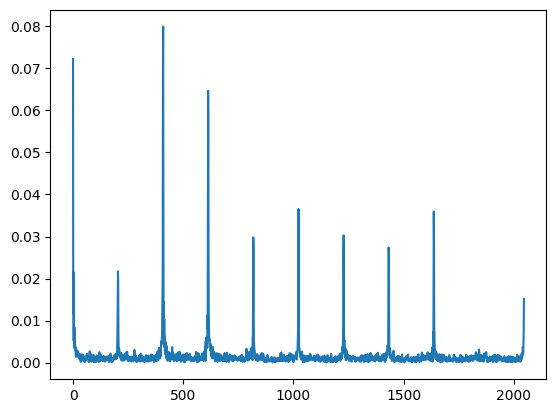

In [181]:
plt.plot(np.abs(rd_tx[1:nfft_tx_doppler//2, tv_bin]))
# plt.plot(freq_tx_vec[1:nfft_tx_doppler//2], np.abs(rd_tx[1:nfft_tx_doppler//2, tv_bin]))
scipy.signal.find_peaks(np.abs(rd_tx[1:nfft_tx_doppler//2, tv_bin]), height=0.01, distance=10)

Text(0.5, 0, 'Frames')

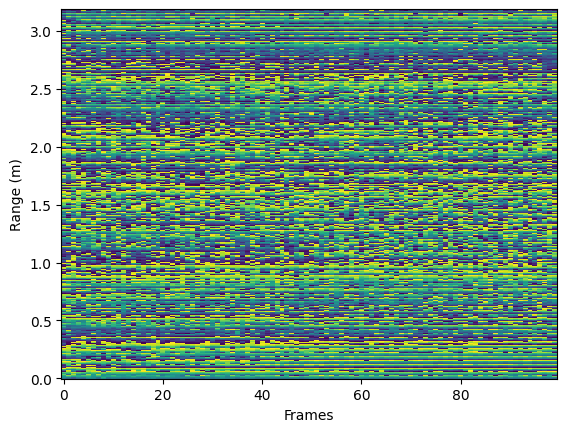

In [125]:
plt.pcolormesh(np.arange(100), dist_vec, np.angle(rp.T))
plt.ylabel("Range (m)")
plt.xlabel("Frames")

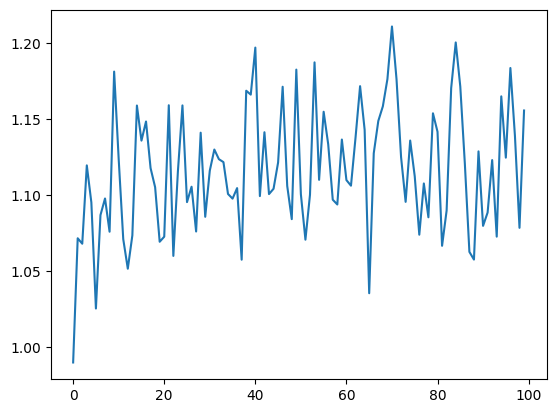

In [191]:
plt.plot(np.angle(rp[:, tv_bin]))

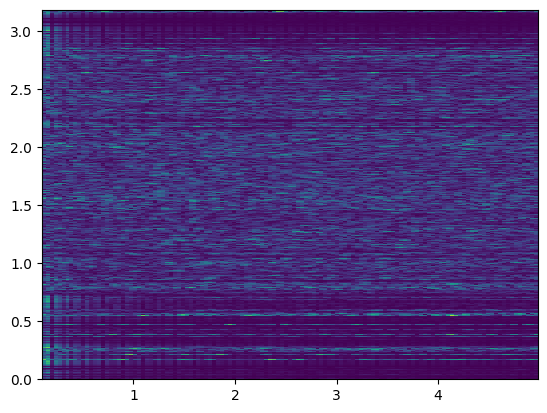

In [192]:
angle_doppler = np.fft.fft(np.angle(rp), axis=0, n=256) # frames, range bins
plt.pcolormesh(freq_vec[3:nfft_doppler//2], dist_vec, np.abs(angle_doppler[3:nfft_doppler//2, :].T))

(199, 100)


Text(0, 0.5, 'Scale')

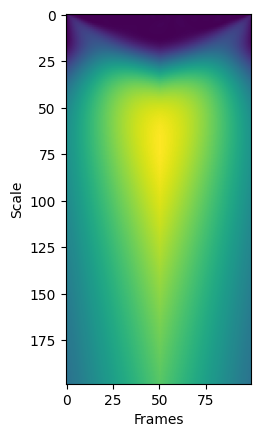

In [200]:
import scipy

cwt_data = np.abs(rp[:, tv_bin])
# cwt_data = np.ones_like(np.abs(rp[:, tv_bin]))
# cwt_data = np.sin(2 * np.pi * 50 * np.arange(100) / 100)

cwt_coeff = scipy.signal.cwt(cwt_data, scipy.signal.ricker, np.arange(1, 200)) # scales, frames
print(cwt_coeff.shape)

plt.imshow(np.abs(cwt_coeff))
plt.xlabel("Frames")
plt.ylabel("Scale")

# plt.plot(cwt_data)
# plt.plot(scipy.signal.ricker(100, 1))

c:\Users\Power_tile\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


Text(0, 0.5, 'Scale of Wavelet')

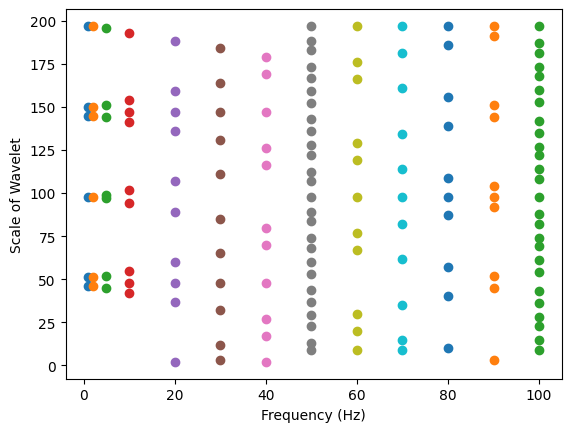

In [184]:
# ! Deprecated
def find_cwt_peaks(freq, i):
    cwt_data = np.sin(2 * np.pi * freq * np.arange(100) / 100)
    cwt_coeff = scipy.signal.cwt(cwt_data, scipy.signal.morlet, np.arange(1, 200)) # scales, frames
    return scipy.signal.find_peaks(np.sum(cwt_coeff, axis=1))

freqs = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for freq in freqs:
    peaks, _ = find_cwt_peaks(freq, 0)
    plt.plot(np.ones(len(peaks)) * freq, peaks, 'o')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Scale of Wavelet")

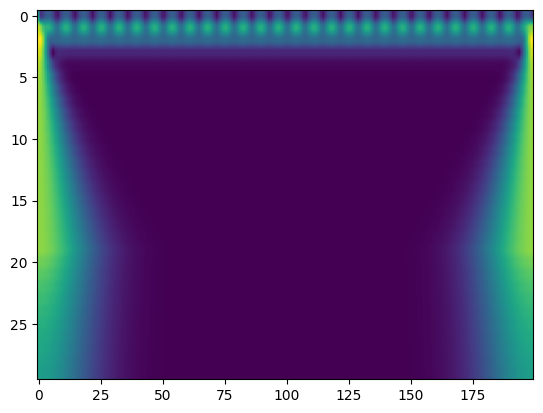

In [164]:
def wavelet_example():
    t = np.linspace(-1, 1, 200, endpoint=False)
    sig = np.cos(2 * np.pi * 7 * t)
    widths = np.arange(1, 31)
    cwtmatr = scipy.signal.cwt(sig, scipy.signal.morlet, widths)

    plt.imshow(np.abs(cwtmatr), aspect='auto')

wavelet_example()